Dans la cellule de code suivante, nous avons lancé plusieurs simulation de notre file pour observer l'évaluation du temps de réponse moyen pour chaque valeur de C {1; 2; 3; 6} en fonction de λ.

In [11]:
import routeur

LAMBDA_REQUETE = 2.3

C = 1

T_MAX = 1000

routeur.simul_fifo(LAMBDA_REQUETE, C, T_MAX)

{'temp_moyen_attente_client': 21.75162589738966, 'taux_rejet': 0.0}

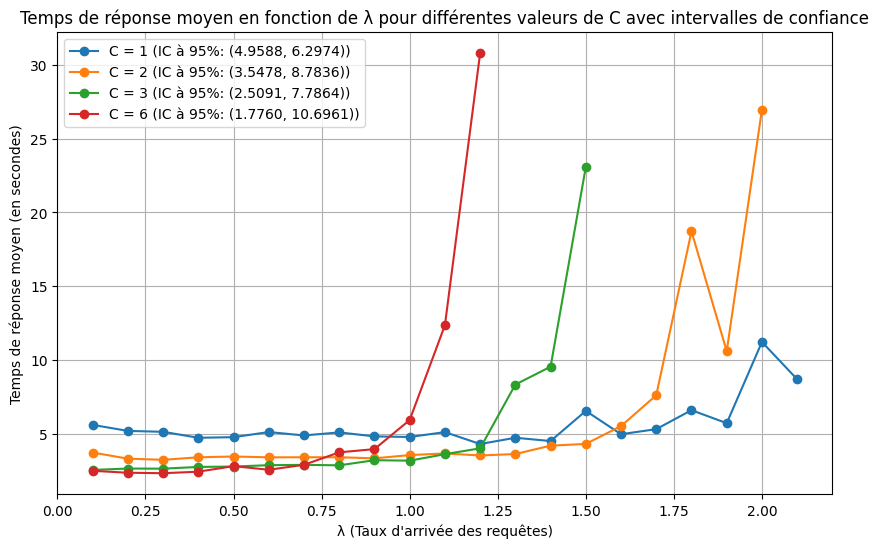

In [78]:
import routeur
import matplotlib.pyplot as plt
import numpy as np

# Paramètres de la simulation
T_MAX = 1000  # Temps maximal de simulation

# Valeurs possibles pour C
C_values = [1, 2, 3, 6]

# Liste pour stocker les résultats pour chaque valeur de C
lambdas_all = []
temps_reponse_moyen_all = []
confidence_intervals_all = []
legends = []

# Simulation pour chaque valeur de C
for C in C_values:
    lambdas = []
    temps_reponse_moyen = []
    confidence_intervals = []
    
    # Initialisation de lambda_requete pour chaque C
    lambda_requete = 0.1

    # Effectuer la simulation pour chaque valeur de lambda_requete
    while True:
        # Simulation
        resultats = routeur.simul_fifo(lambda_requete, C, T_MAX)
        
        # Vérification du taux de rejet
        if resultats["taux_rejet"] > 0.05:
            break
        
        lambdas.append(lambda_requete)
        temps_reponse_moyen.append(resultats["temp_moyen_attente_client"])
        
        # Calcul de la moyenne et de l'écart type
        mean = np.mean(temps_reponse_moyen)
        std_dev = np.std(temps_reponse_moyen)
        n = len(temps_reponse_moyen)

        # Calcul de l'intervalle de confiance à 95%
        confidence_interval = 1.96 * std_dev / np.sqrt(n)

        # Calcul des bornes de l'intervalle de confiance
        lower_bound = mean - confidence_interval
        upper_bound = mean + confidence_interval
        
        confidence_intervals.append((lower_bound, upper_bound))
        
        # Pas de lambda_requete
        lambda_requete += 0.1

    # Stocker les résultats
    lambdas_all.append(lambdas)
    temps_reponse_moyen_all.append(temps_reponse_moyen)
    confidence_intervals_all.append(confidence_intervals)

    # Ajouter l'intervalle de confiance à la légende
    lower_bound, upper_bound = confidence_intervals[-1]  # Utiliser le dernier intervalle
    legends.append(f'C = {C} (IC à 95%: ({lower_bound:.4f}, {upper_bound:.4f}))')

# Tracer les courbes pour chaque valeur de C
plt.figure(figsize=(10, 6))
for i, C in enumerate(C_values):
    plt.plot(lambdas_all[i], temps_reponse_moyen_all[i], marker='o', linestyle='-', label=legends[i])

# Ajouter un titre et des labels
plt.title("Temps de réponse moyen en fonction de λ pour différentes valeurs de C avec intervalles de confiance")
plt.xlabel("λ (Taux d'arrivée des requêtes)")
plt.ylabel("Temps de réponse moyen (en secondes)")
plt.legend()
plt.grid(True)

# Affichage du graphique
plt.show()
